In [1]:
import numpy as np
import pandas as pd
import torch
import os

In [2]:
import grelu.resources
model = grelu.resources.load_model(
    project="borzoi",
    model_name="human_fold0",
)

/n/holylabs/LABS/rc_admin/Lab/mjoshi/gReLU-test/gReLUenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /n/home_rc/mjoshi/.netrc
wandb: Downloading large artifact human_fold0:latest, 711.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:32.8


In [3]:
model.data_params.keys()

dict_keys(['tasks', 'train_seq_len', 'train_label_len', 'train_genome', 'train_bin_size'])

In [4]:
for key in model.data_params.keys():
    if key !="tasks":
        print(key, model.data_params[key])

train_seq_len 524288
train_label_len 16384
train_genome hg38
train_bin_size 32


In [5]:
tasks = pd.DataFrame(model.data_params['tasks'])
tasks.head(3)

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
0,CNhs10608+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,1,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
1,CNhs10608-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,0,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
2,CNhs10610+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,3,CAGE:SABiosciences XpressRef Human Universal T...,CAGE,SABiosciences XpressRef Human Universal Total ...


In [6]:
input_len = model.data_params["train_seq_len"]
chrom = "chr1"
input_start = 69993520
input_end = input_start + input_len

In [7]:
input_intervals = pd.DataFrame({
    'chrom':[chrom], 'start':[input_start], 'end':[input_end], "strand":["+"],
})

input_intervals

,chrom,start,end,strand
0,chr1,69993520,70517808,+


In [8]:
import grelu.sequence.format

input_seqs = grelu.sequence.format.convert_input_type(
    input_intervals,
    output_type="strings",
    genome="hg38"
)
input_seq = input_seqs[0]

len(input_seq)

11:30:19 | INFO | Downloading assembly summaries from GENCODE
11:30:40 | INFO | Downloading assembly summaries from UCSC
11:30:44 | INFO | Downloading assembly summaries from Ensembl
11:30:57 | INFO | Downloading genome from UCSC. Target URL: https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz...
Download: 100%|██████████| 938M/938M [01:29<00:00, 11.0MB/s]  
11:32:27 | INFO | Genome download successful, starting post processing...
11:33:24 | INFO | name: hg38
11:33:24 | INFO | local name: hg38
11:33:24 | INFO | fasta: /n/home_rc/mjoshi/.local/share/genomes/hg38/hg38.fa
Filtering Fasta: 64.2M lines [01:52, 572k lines/s]


524288

In [9]:
input_seq[:10]

'ACTGTGCACC'

In [10]:
%%time
preds = model.predict_on_seqs(input_seqs, device=0)
preds.shape

CPU times: user 804 ms, sys: 397 ms, total: 1.2 s
Wall time: 1.7 s


(1, 7611, 6144)

In [11]:
output_intervals = model.input_intervals_to_output_intervals(input_intervals)
output_intervals

,chrom,start,end,strand
0,chr1,70157360,70353968,+


In [12]:
output_start = output_intervals.start[0]
output_end = output_intervals.end[0]
output_len = output_end - output_start
print(output_len)

196608


In [13]:
import grelu.visualize
%matplotlib inline

In [14]:
cage_brain_tasks = tasks[(tasks.assay=="CAGE") & (tasks["sample"].str.contains("brain"))].head(2)
rna_brain_tasks = tasks[(tasks.assay=="RNA") & (tasks["sample"].str.contains("brain"))].head(2)

tasks_to_plot = cage_brain_tasks.index.tolist() + rna_brain_tasks.index.tolist()
task_names = tasks.description[tasks_to_plot].tolist() # Description of these tracks from the `tasks` dataframe

print(tasks_to_plot)
print(task_names)

[10, 11, 6635, 6636]
['CAGE:brain, adult, pool1', 'CAGE:brain, adult, pool1', 'RNA:brain tissue female adult (66 years)', 'RNA:brain tissue female adult (66 years)']


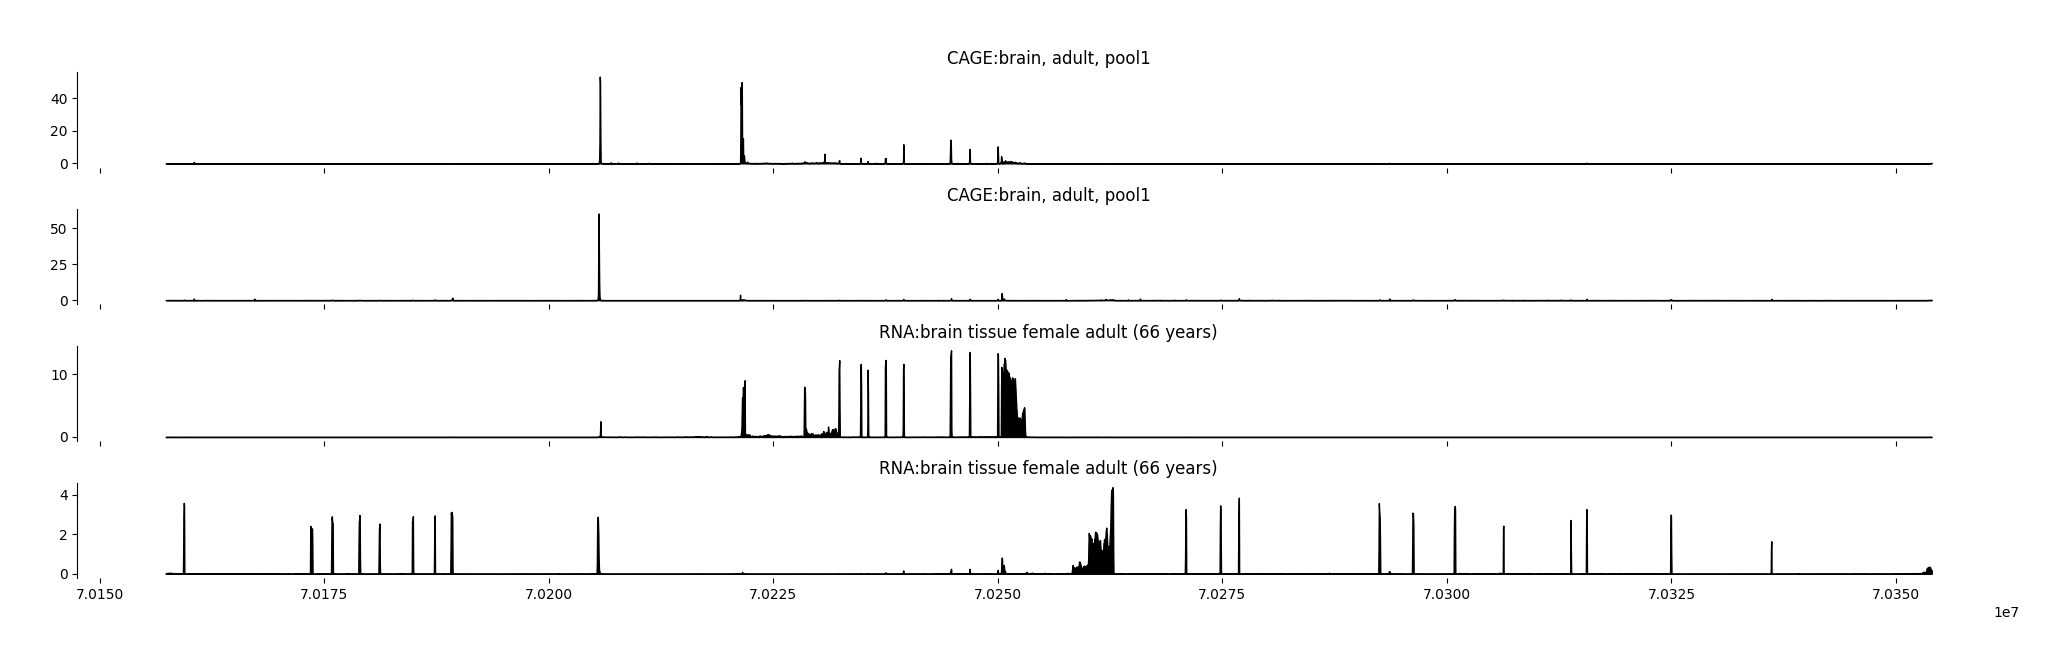

In [15]:
fig = grelu.visualize.plot_tracks(
    preds[0, tasks_to_plot, :], # Outputs to plot
    start_pos=output_start, # Start coordinate for the x-axis label
    end_pos=output_end, # End coordinate for the x-axis label
    titles=task_names, # titles for each track
    figsize=(20, 6), # width, height
)